In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from load import split_df, sort_links
from common import transform, fit_scale, roll, eval_quantiles, compute_error
from get_data import get_dat
import pandas as pd

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Tensorflow and numpy versions 

In [2]:
print("Tensorflow Probability Version .{}".format(tfp.__version__))
print("Tensorflow Version .{}".format(tf.__version__))
print("Numpy Version .{}".format(np.__version__))

Tensorflow Probability Version .0.8.0-rc0
Tensorflow Version .2.0.0-rc1
Numpy Version .1.17.2


In [579]:
lags = 20
preds = 1
start_train = '2019-01-01'
end_train = '2019-02-01' 
end_test = '2019-02-07'

data = pd.read_csv('../data/link_travel_time_local.csv.gz', compression='gzip', parse_dates = True, index_col = 0)

## Sort links by order 
data, order = sort_links(data, '1973:1412', '7057:7058')
## Make a link order column e.g here the neighbouring links for link 1 are 0 and 2.
data['link_order'] = data['link_ref'].astype('category')
not_in_list = data['link_order'].cat.categories.difference(order)
data['link_order'] = data['link_order'].cat.set_categories(np.hstack((order, not_in_list)), ordered=True)
data['link_order'] = data['link_order'].cat.codes
## Add week of day column [Monday, ..., Sunday] = [0, ..., 6]
data['Weekday'] = data.index.weekday_name
data = data.sort_values('link_order')
data_train, data_test = split_df(data, start_train = start_train, end_train = end_train, end_test = end_test)

## Transform train and test set using the mean and std for train set.
means_df, scales, low_df, upr_df = fit_scale(data_train, order)
ix_train, ts_train,  rm_mean_train, rm_scale_train, w_train, lns_train = transform(data_train, 
                                                                                       means_df, 
                                                                                       scales, 
                                                                                       order,
                                                                                       freq = '15min')
ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lns_test = transform(data_test, 
                                                                                 means_df, 
                                                                                 scales, 
                                                                                 order,
                                                                                 freq = '15min')
## Create rolling window tensor
##  - y_mean and y_std are arrays where columns are each link and 
##    the rows corresponding to the mean and std of each data point
##    at that weekday. 

##  - y_num_meas indicates how many measurements are in the time window
##    for a given link
X_train, y_train, y_ix_train, y_mean_train, y_std_train, y_num_meas_train = roll(ix_train, 
                                                                                 ts_train, 
                                                                                 rm_mean_train, 
                                                                                 rm_scale_train, 
                                                                                 w_train, 
                                                                                 lags, 
                                                                                 preds)
X_test, y_test, y_ix_test, y_mean_test, y_std_test, y_num_meas_test = roll(ix_test, 
                                                                           ts_test, 
                                                                           rm_mean_test, 
                                                                           rm_scale_test, 
                                                                           w_test, 
                                                                           lags, 
                                                                           preds)
## Select three interesting links
X_train = X_train[:,:,3]
X_test = X_test[:,:,3]
y_train = y_train[:,:,3]
y_test = y_test[:,:,3]

X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
y_train = y_train[:,:,np.newaxis]
y_test = y_test[:,:,np.newaxis]

In [580]:
X_train.shape

(3050, 20, 1)

In [581]:
def compute_KL(theta, sample, prior):
        sample = tf.reshape(sample, [-1])  #flatten vector
        (mean,std) = theta
        mean = tf.reshape(mean, [-1])
        std = tf.reshape(std, [-1])
        posterior = tfd.Normal(mean, std)

        q_theta = tf.reduce_sum(posterior.log_prob(sample))
        p_d = tf.reduce_sum(prior.log_prob(sample))

        KL = tf.subtract(q_theta, p_d)
        return KL

class CustomScaleMixture(object):
    def __init__(self, pi, sigma1, sigma2):
        self.mu, self.pi, self.sigma1, self.sigma2 = (np.float32(v) for v in (0.0, pi, sigma1, sigma2))

    def log_prob(self, x):
        n1 = tfp.distributions.Normal(self.mu, self.sigma1)
        n2 = tfp.distributions.Normal(self.mu, self.sigma2)
        mix1 = tf.reduce_sum(n1.log_prob(x), -1) + tf.math.log(self.pi)
        mix2 = tf.reduce_sum(n2.log_prob(x), -1) + tf.math.log(np.float32(1.0 - self.pi))
        prior_mix = tf.stack([mix1, mix2])
        lse_mix = tf.reduce_logsumexp(prior_mix, [0])
        return tf.reduce_sum(lse_mix)

<a id='basic_model'></a>
# Basic (Vanilla) RNN Model

In [582]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.stdNorm = tfd.Normal(0,1)
    
    @property
    def sigma(self):
        return tf.math.softplus(self.rho)
    
    def sample(self):
        epsilon = self.stdNorm.sample(tf.shape(self.rho))
        return self.mu + self.sigma*epsilon
    
    def log_prob(self, _input):
        return tf.reduce_sum(-tf.math.log(tf.math.sqrt(2 * math.pi))
                - tf.math.log(self.sigma)
                - ((_input - self.mu) ** 2) / (2 * self.sigma ** 2))

In [583]:
sum_all = tf.math.reduce_sum
class MinimalRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, training, **kwargs):
        super(MinimalRNNCell, self).__init__(**kwargs)
        self.is_training = training
        self.units = units
        self.state_size = (units)
        self.prior = tfd.Normal(0,1)

    def initialise_rnn(self, links):
        self.W_mu = self.add_weight(shape=(1, self.units),
                                      initializer='zeros',
                                      name='W_mu', trainable=True)
        self.W_rho = self.add_weight(shape=(1, self.units),
                                      initializer='zeros',
                                      name='W_rho', trainable=True)
        self.U_mu = self.add_weight(shape=(self.units, self.units),
                                    initializer='zeros',
                                    name='U_mu', trainable=True)
        self.U_rho = self.add_weight(shape=(self.units, self.units),
                                    initializer='zeros',
                                    name='U_rho', trainable=True)
        self.W_dist = Gaussian(self.W_mu, self.W_rho)
        self.U_dist = Gaussian(self.U_mu, self.U_rho)
        ## Make sure following is only printed once during training and not for testing!
        print("  Cell has been built")
        self.sampling = True
        self.built = True
    
    def call(self, inputs, states):
        if self.is_training:
            self.W = self.W_dist.sample()
            self.U = self.U_dist.sample()
            self.log_prior = sum_all(self.prior.log_prob(self.W)) + sum_all(self.prior.log_prob(self.U))
            self.log_variational_posterior = self.W_dist.log_prob(self.W) + self.U_dist.log_prob(self.U)
        elif self.sampling:
            self.W = tfd.Normal(self.W_mu, tf.math.softplus(self.W_rho)).sample()
            self.U = tfd.Normal(self.U_mu, tf.math.softplus(self.U_rho)).sample()
        else:
            self.W = self.W_mu
            self.U = self.U_mu
            
        prev_output = states[0]
        h = tf.linalg.matmul(inputs, self.W)
        output = h + tf.linalg.matmul(prev_output, self.U)
        return output, [output]

    def get_initial_state(self, inputs = None, batch_size = None, dtype = None):
        return [tf.zeros((batch_size, self.state_size), dtype = dtype)]

In [584]:
class BasicNet(tf.keras.layers.Layer):
    def __init__(self, num_units, num_links, batch_size, num_batches, **kwargs):
        super(BasicNet, self).__init__(**kwargs)
        self.num_units = num_units
        self.shape = num_links
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.cell_built=False
        self.build()
    
    def build(self):
        print("Building net...")
        self.cell = MinimalRNNCell(self.num_units, training=True)
        self.cell.initialise_rnn(self.shape)
        self.cell_built=True
        self.weight = self.add_weight(shape=(self.num_units,1),
                                 initializer='zeros',
                                 name='weight')
        self.bias = self.add_weight(shape=(1,),
                                     initializer='zeros',
                                     name='bias', trainable=True)
        print("  Output layer has been built")
        self.y_rho = self.add_weight(shape=(1,),
                                     initializer='zeros',
                                     name='y_rho',
                                     trainable=True)
        self.built = True
    
    @property
    def y_std(self):
        return tf.math.softplus(self.y_rho)

    def call(self, batch_x, training, sampling=True):
        self.cell.is_training = training
        self.cell.sampling = sampling
        
        inputs = tf.convert_to_tensor(batch_x)
        initial_state = self.cell.get_initial_state(inputs, self.batch_size, tf.float32)
        rnn = tf.keras.layers.RNN(self.cell, return_sequences=False)
        final_rnn_output = rnn(inputs, initial_state)
        self.outputs = tf.linalg.matmul(final_rnn_output, self.weight) + self.bias
    
        return self.outputs
    
    def log_prior(self):
        return tf.math.reduce_sum(self.cell.log_prior)
    
    def log_variational_posterior(self):
        return self.cell.log_variational_posterior
    
    def elbo(self, batch_x, batch_y):
        output = self(batch_x, training=True)
        assert(output.shape == batch_y.shape)
        pred_dist = tfd.Normal(output, scale=self.y_std)
        nll = -tf.math.reduce_sum(pred_dist.log_prob(batch_y))
        return (self.log_variational_posterior() - self.log_prior())/self.num_batches + nll

In [585]:
batch_size = 32
num_batch_train = int(X_train.shape[0]/batch_size)
num_batch_test = int(X_test.shape[0]/batch_size)

print("Batch size 32, with", num_batch_train, "batches for training and", num_batch_test, "batches for testing")

data_train = tf.data.Dataset.from_tensor_slices((X_train[:(num_batch_train*batch_size)], 
                                                 y_train[:(num_batch_train*batch_size)])).batch(batch_size)
data_test = tf.data.Dataset.from_tensor_slices((X_test[:(num_batch_test*batch_size)], 
                                                y_test[:(num_batch_test*batch_size)])).batch(batch_size)

Batch size 32, with 95 batches for training and 20 batches for testing


Building net...
  Cell has been built
  Output layer has been built


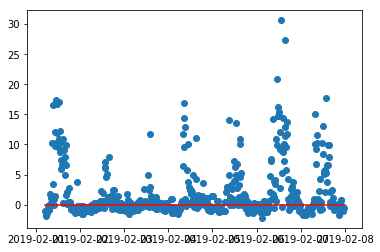

0
tf.Tensor(486.5484, shape=(), dtype=float32)
tf.Tensor(20275.398, shape=(), dtype=float32)


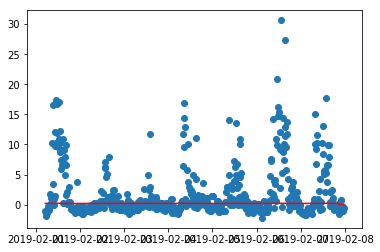

1
tf.Tensor(486.5484, shape=(), dtype=float32)
tf.Tensor(14111.186, shape=(), dtype=float32)


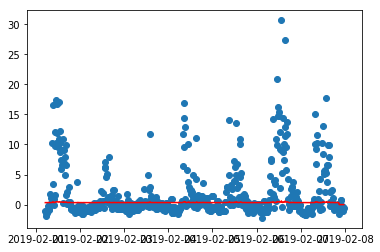

2
tf.Tensor(486.5484, shape=(), dtype=float32)
tf.Tensor(11065.1455, shape=(), dtype=float32)


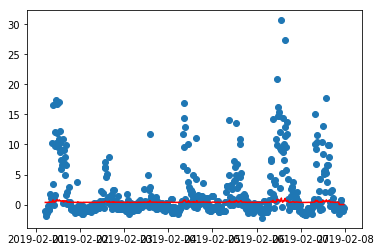

3
tf.Tensor(486.5484, shape=(), dtype=float32)
tf.Tensor(10320.995, shape=(), dtype=float32)


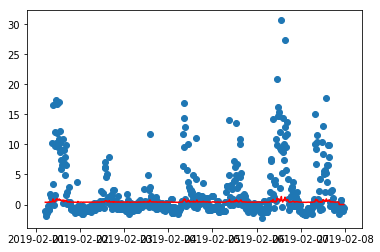

EPOCH: 5 / 120
4
tf.Tensor(486.5484, shape=(), dtype=float32)
tf.Tensor(9101.545, shape=(), dtype=float32)


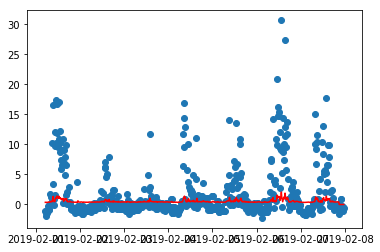

5
tf.Tensor(486.5484, shape=(), dtype=float32)
tf.Tensor(8639.575, shape=(), dtype=float32)


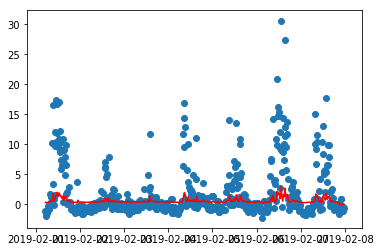

6
tf.Tensor(486.5484, shape=(), dtype=float32)
tf.Tensor(8394.527, shape=(), dtype=float32)


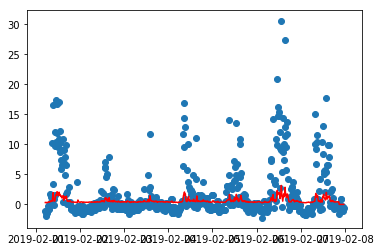

7
tf.Tensor(486.5484, shape=(), dtype=float32)
tf.Tensor(8119.952, shape=(), dtype=float32)


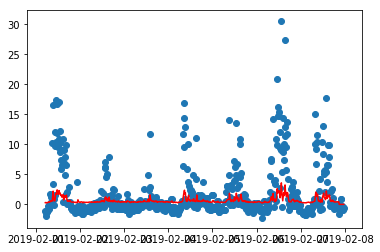

8
tf.Tensor(486.5484, shape=(), dtype=float32)
tf.Tensor(8242.504, shape=(), dtype=float32)
Early stopping after 8 epochs


In [639]:
lr = 1e-2
epochs = 120
patience = 8
optimizer = tf.keras.optimizers.Adam(lr = lr)
loss_lst = []
best_elbo = 1000000000000000

num_units = 3
num_links = 1
net = BasicNet(num_units, num_links, batch_size, num_batch_train)
for epoch in range(epochs):
    ## Print the fitted training data
    y_pred = np.zeros((y_test.shape[0],1))
    T = 0
    for x_batch, _ in data_test:
        x = tf.cast(x_batch,tf.float32)
        y_pred[T*batch_size:(T+1)*batch_size] = net(x, training=False, sampling=False)
        T = T+1
    plt.plot(y_ix_test, y_pred, c='r')
    plt.scatter(y_ix_test, y_test[:,0,:])
    plt.show()
    
    elbo_sum = 0
    if (epoch+1) % 5 == 0:
        print("EPOCH:", epoch+1, "/", epochs)
    for batch_x, batch_y in data_train:
        x = tf.cast(batch_x, tf.float32)
        y = tf.cast(batch_y, tf.float32)
        with tf.GradientTape() as tape:
            loss = net.elbo(x, y[:,0,:])
        gradients = tape.gradient(loss, net.trainable_variables)
        optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        elbo_sum += loss
    
    if elbo_sum.numpy() < best_elbo:
        best_elbo = loss
        patience_counter = 0

    print(patience_counter)
    print(best_elbo)
    print(elbo_sum)
    
    patience_counter = patience_counter + 1
    if patience_counter > patience:
        print("Early stopping after", epoch, "epochs")
        break
    
    loss_lst.append(elbo_sum / num_batch_train)

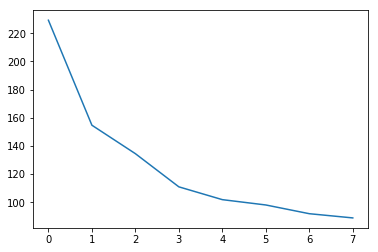

In [636]:
plt.plot(loss_lst)

In [630]:
patience = 8
best_elbo = 10000000000000
for idx,loss in enumerate(loss_lst):
    if loss.numpy() < best_elbo:
        best_elbo = loss
        patience_counter = 0

    patience_counter = patience_counter + 1
    if patience_counter > patience:
        print(idx)
        break
    #print(patience_counter)

63


In [589]:
nsamples = 200
y_pred = np.empty((nsamples, y_test.shape[0],1))
T = 0
for x_batch, _ in data_test:
    x = tf.cast(x_batch,tf.float32)
    for n in range(nsamples):
        y_pred[n, T*batch_size:(T+1)*batch_size] = net(x, training=False, sampling=True)
    T = T+1

In [590]:
quantiles = np.array([0.10, 0.90])
lwr = np.quantile(y_pred, quantiles[0], axis=0)
upr = np.quantile(y_pred, quantiles[1], axis=0)
med = np.mean(y_pred, axis=0)

In [601]:
print(upr[1:10])
print(lwr[1:10])

[[-0.73268514]
 [-1.12680615]
 [-0.90673789]
 [-0.74592861]
 [-0.86440426]
 [-0.65073167]
 [-0.28119557]
 [-0.41669271]
 [-0.46005856]]
[[-0.90026398]
 [-1.30588005]
 [-1.09541423]
 [-0.91167585]
 [-1.04285607]
 [-0.82449455]
 [-0.43988818]
 [-0.56777322]
 [-0.5916187 ]]


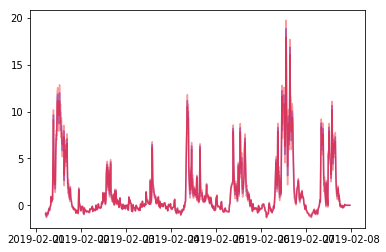

In [598]:
plt.plot(y_ix_test,med, "b-", alpha=0.4)
plt.plot(y_ix_test,lwr, "r-", alpha = 0.4)
plt.plot(y_ix_test,upr, "r-", alpha = 0.4)
plt.scatter(y_ix_test,y_test[:,0,:])

In [578]:
(np.sum(y_test[:,0,:] < lwr) + np.sum(y_test[:,0,:] > upr) )/len(y_test)

0.8274509803921568

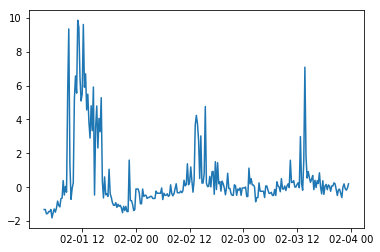

In [410]:
plt.plot(y_ix_test,y_test[:,0,:])

In [354]:
(epoch+1) % 5

0

In [181]:
def train(net, data_train, batch_size, num_batches, lr):
    optimizer = tf.keras.optimizers.Adam(lr = lr)
    for x_batch, y_batch in data_train:
        with tf.GradientTape() as tape:
            elbo = net.sample_elbo(x_batch, y_batch, batch_size, num_batches)
            print(elbo)
        gradients = tape.gradient(elbo, net.trainable_variables)
        print(gradients)
        optimizer.apply_gradients(zip(gradients, net.trainable_variables))

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, RNN
import math
DenseFlipout = tfp.layers.DenseFlipout
DenseVariational = tfp.layers.DenseVariational
DistributionLambda = tfp.layers.DistributionLambda

tf.keras.backend.set_floatx('float32')
mod = Sequential()
mod.add(Input(shape = (X_train.shape[1], 1)))
mod.add(RNN(MinimalRNNCell(8, False), return_sequences = False, dtype = tf.float32))
mod.add(Dense(1))

negloglik = lambda y, f: -tf.reduce_sum(f.log_prob(y))

mod.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss='mse')
mod.fit(X_train, y_train, epochs=10, verbose=False)
y_pred = mod(X_test)

KeyboardInterrupt: 

In [46]:
mod.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_5 (RNN)                  (None, 8)                 144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [39]:
for i in range(len(mod.trainable_variables)):
    print(mod.trainable_variables[i].name)

rnn_4/W_mu:0
rnn_4/W_mu:0
rnn_4/U_mu:0
rnn_4/U_rho:0
dense/kernel:0
dense/bias:0


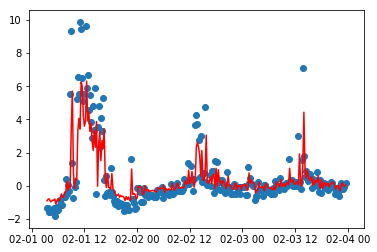

In [45]:
plt.plot(y_ix_test, y_pred, c='r')
plt.scatter(y_ix_test, y_test)

In [24]:
y_pred = np.zeros((y_test.shape[0], 1))
T = 0
for x_batch, __ in data_test:
    state = var_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
    for t in range(X_train.shape[1]):
        net, state = var_cell(x_batch[:,t,:], state)
    print(T*batch_size,(T+1)*batch_size)
    y_pred[T*batch_size:(T+1)*batch_size] = out_layer(net)
    t = t+1

ValueError: too many values to unpack (expected 2)

In [334]:
t*batch_size

460

In [322]:
tf.keras.backend.set_floatx('float32')

lr = 1e-2
batch_size = 20
EPOCHS = 50
PATIENCE = 20
num_batch_train = int(X_train.shape[0]/batch_size)
num_batch_test = int(X_test.shape[0]/batch_size)

N = X_train.shape[0]
data_train = tf.data.Dataset.from_tensor_slices((X_train[:(num_batch_train*batch_size)], 
                                                 y_train[:(num_batch_train*batch_size)])).batch(batch_size)
data_test = tf.data.Dataset.from_tensor_slices((X_test[:(num_batch_test*batch_size)], 
                                                y_test[:(num_batch_test*batch_size)])).batch(batch_size)

optimizer = tf.keras.optimizers.Adam(lr = lr)
var_cell = MinimalRNNCell(24, True)
out_layer = tf.keras.layers.Dense(1)
for x_batch, y_batch in data_train:
    state = var_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
    nll = 0
    for t in range(X_train.shape[1]):
        net, state = var_cell(x_batch[:,t,:], state)
    output = out_layer(net)

    with tf.GradientTape() as tape:
        nll = -tf.reduce_sum(tfd.Normal(output, scale=1).log_prob(y_batch))
        kl = tf.reduce_sum(var_cell.losses) / batch_size
        loss = kl + nll
    gradients = tape.gradient(loss, out_layer.trainable_variables + var_cell.trainable_variables)
    optimizer.apply_gradients(zip(gradients, out_layer.trainable_variables + var_cell.trainable_variables))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
for x_batch, y_batch in data_train:
    var_cell = MinimalRNNCell(24, False)
    out_layer = tf.keras.layers.Dense(1)
    state = var_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
    nll = 0
    for t in range(X_train.shape[1]):
        net, state = var_cell(x_batch[:,t,:], state)
    output = out_layer(net)

[Click to get back to model instantiation](#instantiate)

In [279]:
tf.keras.backend.set_floatx('float32')
mod = Sequential()
mod.add(Input(shape = (X_train.shape[1], 1)))
mod.add(RNN(MinimalRNNCell(8, True), return_sequences = False, dtype = tf.float32))
mod.add(DenseFlipout(1))

negloglik = lambda y, f: -tf.reduce_sum(f.log_prob(y))

mod.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss='mse')
mod.fit(X_train, y_train, epochs=10, verbose=False)
y_pred = mod(X_test)

In [154]:
loss_sum.shape

TensorShape([20, 20])

In [155]:
# Fit the model
elb_train_lst = []
elb_test_lst = []
best_elbo_test = 1000000000

print("Training with batch size", batch_size, "for", num_batch_train, "batches")

for epoch in range(EPOCHS):
    loss_sum = 0
    for x_data, y_data in data_train:
        loss = train_step(x_data, y_data)
        loss_sum += loss

    print("EPOCH", epoch + 1, " / ", EPOCHS, 
          "avg batch training loss = ", loss_sum.numpy()/num_batch_train)
    elb_train_lst.append(loss_sum / num_batch_train)

Training with batch size 20 for 32 batches

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

EPOCH 1  /  50 avg batch training loss =  [1223.3033]
EPOCH 2  /  50 avg batch training loss =  [1351.6722]
EPOCH 3  /  50 avg batch training loss =  [1399.2853]
EPOCH 4  /  50 avg batch training loss =  [1513.7855]
EPOCH 5  /  50 avg batch training loss =  [1255.3408]
EPOCH 6  /  50 avg batch training loss =  [1398.3416]
EPOCH 7  /  50 avg batch training loss =  [1228.0515]
EPOCH 8  /  50 avg batch training loss =  [1351.389]
EPOCH 9  /  50 avg batch training 

KeyboardInterrupt: 

In [123]:
np.log(1 + np.exp(-2.55))

0.07518322657579009

In [120]:
mod.fit(X_train, y_train, epochs = 20, verbose = 0)
y_pred = mod.predict(X_test)

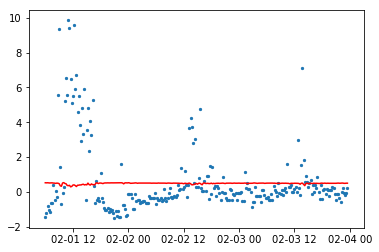

In [204]:
plt.plot(y_ix_test, ypred.mean(), c='r')
plt.scatter(y_ix_test, y_test[:,:,0], s=5)

[Click to get back to model instantiation](#instantiate)

In [422]:
## Change all layers to have dtype float64 
tf.keras.backend.set_floatx('float32')

## Instantiate model
batch_size = 30 ## Problem <- right now n_samples has to be divisible by batch size
pi = 0.2
sigma1 = np.exp( 2)
sigma2 = np.exp(-9)
lr = 1e-1

mod = RNNBasic(batch_size, 
                     X_train.shape[1], 
                     X_train.shape[2],
                     y_train.shape[1], 
                     lstm_sizes,
                     pi,
                     sigma1, 
                     sigma2)
optimizer = tf.keras.optimizers.Adam(lr = lr)
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        out = mod(x_batch, training=True)
        loss = mod.losses(y_batch)
    gradients = tape.gradient(loss, mod.trainable_variables)
    optimizer.apply_gradients(zip(gradients, mod.trainable_variables))
    return loss

EPOCHS = 10
num_batch_train = int(X_train.shape[0]/batch_size)
num_batch_test = int(X_test.shape[0]/batch_size)

assert(batch_size*num_batch_train <= X_train.shape[0] )
assert(batch_size*num_batch_test <= X_test.shape[0] )

N = X_train.shape[0]
data_train = tf.data.Dataset.from_tensor_slices((X_train[:(num_batch_train*batch_size)], 
                                                 y_train[:(num_batch_train*batch_size)])).batch(batch_size)
data_test = tf.data.Dataset.from_tensor_slices((X_test[:(num_batch_test*batch_size)], 
                                                y_test[:(num_batch_test*batch_size)])).batch(batch_size)

Training with batch size 30 for 21 batches

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

EPOCH 1  /  10 avg batch training loss =  148.99255952380952
EPOCH 2  /  10 avg batch training loss =  132.66565522693452
EPOCH 3  /  10 avg batch training loss =  140.55035109747024
EPOCH 4  /  10 avg batch training loss =  126.00646391369048
EPOCH 5  /  10 avg batch training loss =  138.46270461309524
EPOCH 6  /  10 avg batch training loss =  128.98080589657738
EPOCH 7  /  10 avg batch training loss =  121.7587658110119
EPOCH 8  /  10 avg batch training loss 

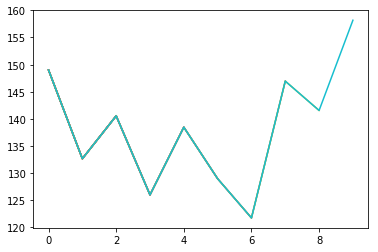

In [424]:
# Fit the model
elb_train_lst = []
elb_test_lst = []
best_elbo_test = 1000000000

print("Training with batch size", batch_size, "for", num_batch_train, "batches")

for epoch in range(EPOCHS):
    loss_sum = 0
    for x_data, y_data in data_train:
        loss = train_step(x_data, y_data)
        loss_sum += loss

    print("EPOCH", epoch + 1, " / ", EPOCHS, 
          "avg batch training loss = ", loss_sum.numpy()/num_batch_train)
    elb_train_lst.append(loss_sum / num_batch_train)
    
    ## Plot every 10 epochs
    plt.plot(elb_train_lst)
    plt.plot(elb_test_lst, c='r')

Testing with batch size 30 for 8 batches


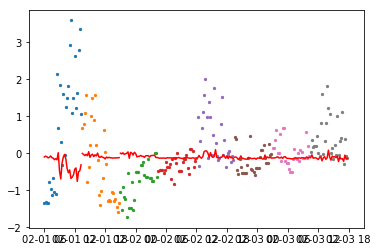

In [426]:
print("Testing with batch size", batch_size, "for", num_batch_test, "batches")

lnk = 1
y_pred = np.empty( (num_batch_test*batch_size, y_test.shape[2]))
t = 0
for x_data, y_data in data_test:
    y_pred[t*batch_size:(t+1)*batch_size] = mod(x_data, training=False)
    plt.plot(y_ix_test[t*batch_size:(t+1)*batch_size], y_pred[t*batch_size:(t+1)*batch_size,lnk], c = 'r')
    plt.scatter(y_ix_test[t*batch_size:(t+1)*batch_size], y_test[t*batch_size:(t+1)*batch_size,:,lnk], s=5)
    t = t+1

<a id='untied_model'></a>
# Untied Weights LSTM Model

In [275]:
class BayesianLSTMCell_Untied(tf.keras.Model):
    def __init__(self, num_units, batch_size, links, prior, is_training, name, 
                 Ui_mu, Ui_rho,
                 Wi_mu, Wi_rho,
                 Uo_mu, Uo_rho,
                 Wo_mu, Wo_rho,
                 Uf_mu, Uf_rho,
                 Wf_mu, Wf_rho,
                 Ug_mu, Ug_rho,
                 Wg_mu, Wg_rho,
                 **kwargs):
        super(BayesianLSTMCell_Untied, self).__init__(num_units, **kwargs)
        self.prior = prior
        self.layer_name = name
        self.isTraining = is_training
        self.num_units = num_units
        self.state_size = num_units
        self.links = links
        
        self.is_training = is_training
        
        self.w = None
        self.b = None
        self.kl_w = None
        self.kl_b = None
        
        self.Ui_mu =  Ui_mu
        self.Ui_rho = Ui_rho
        self.Uo_mu =  Uo_mu
        self.Uo_rho = Uo_rho
        self.Uf_mu =  Uf_mu
        self.Uf_rho = Uf_rho
        self.Ug_mu =  Ug_mu
        self.Ug_rho = Ug_rho
        
        self.Wi_mu =  Wi_mu
        self.Wi_rho = Wi_rho
        self.Wo_mu =  Wo_mu
        self.Wo_rho = Wo_rho
        self.Wf_mu =  Wf_mu
        self.Wf_rho = Wf_rho
        self.Wg_mu =  Wg_mu
        self.Wg_rho = Wg_rho
        self.built = True
        
    @property
    def Ui(self):
        self.Ui_sigma = tf.math.softplus(self.Ui_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.Ui_mu))
            sample = self.Ui_mu+self.Ui_sigma*epsilon
        else:
            sample = tfd.Normal(self.Ui_mu, self.Ui_sigma).sample()
            #sample = self.Ui_mu+self.Ui_sigma
        return sample
    
    @property
    def Uo(self):
        self.Uo_sigma = tf.math.softplus(self.Uo_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.Uo_mu))
            sample = self.Uo_mu+self.Uo_sigma*epsilon
        else:
            sample = tfd.Normal(self.Uo_mu, self.Uo_sigma).sample()
            #sample = self.Uo_mu+self.Uo_sigma
        return sample
    
    @property
    def Uf(self):
        self.Uf_sigma = tf.math.softplus(self.Uf_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.Uf_mu))
            sample = self.Uf_mu+self.Uf_sigma*epsilon
        else:
            sample = tfd.Normal(self.Uf_mu, self.Uf_sigma).sample()
            #sample = self.Uf_mu+self.Uf_sigma
        return sample

    @property
    def Ug(self):
        self.Ug_sigma = tf.math.softplus(self.Ug_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.Ug_mu))
            sample = self.Ug_mu+self.Ug_sigma*epsilon
        else:
            sample = tfd.Normal(self.Ug_mu, self.Ug_sigma).sample()
            #sample = self.Ug_mu+self.Ug_sigma
        return sample
    
    @property
    def Wi(self):
        self.Wi_sigma = tf.math.softplus(self.Wi_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.Wi_mu))
            sample = self.Wi_mu+self.Wi_sigma*epsilon
        else:
            sample = tfd.Normal(self.Wi_mu, self.Wi_sigma).sample()
            #sample = self.Wi_mu+self.Wi_sigma
        return sample
    
    @property
    def Wo(self):
        self.Wo_sigma = tf.math.softplus(self.Wo_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.Wo_mu))
            sample = self.Wo_mu+self.Wo_sigma*epsilon
        else:
            sample = tfd.Normal(self.Wi_mu, self.Wi_sigma).sample()
            #sample = self.Wo_mu+self.Wo_sigma
        return sample
    
    @property
    def Wf(self):
        self.Wf_sigma = tf.math.softplus(self.Wf_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.Wf_mu))
            sample = self.Wf_mu+self.Wf_sigma*epsilon
        else:
            sample = tfd.Normal(self.Wf_mu, self.Wf_sigma).sample()
            #sample = self.Wf_mu+self.Wf_sigma
        return sample

    @property
    def Wg(self):
        self.Wg_sigma = tf.math.softplus(self.Wg_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.Wg_mu))
            sample = self.Wg_mu+self.Wg_sigma*epsilon
        else:
            sample = tfd.Normal(self.Wg_mu, self.Wg_sigma).sample()
            #sample = self.Wg_mu+self.Wg_sigma
        return sample
    
    
    def call(self, inputs, states):
        c_t, h_t = tf.split(value=states[0], num_or_size_splits=2, axis=0)
        
        inputs = tf.cast(inputs, tf.float32)
        i = tf.sigmoid(tf.linalg.matmul(h_t, self.Ui) + tf.linalg.matmul(inputs, self.Wi))
        o = tf.sigmoid(tf.linalg.matmul(h_t, self.Uo) + tf.linalg.matmul(inputs, self.Wo))
        f = tf.sigmoid(tf.linalg.matmul(h_t, self.Uf) + tf.linalg.matmul(inputs, self.Wf))
        g = tf.math.tanh(tf.linalg.matmul(h_t, self.Ug) + tf.linalg.matmul(inputs, self.Wg))
        
        c_new = f*c_t + i*g
        h_new = o*tf.math.tanh(c_new)
        new_state = tf.concat([c_new, h_new], axis=0)
        return h_new, new_state
    
    def get_initial_state(self, inputs = None, batch_size = None, dtype = None):
        return tf.zeros((2*batch_size, self.state_size), dtype = dtype)

[Click to get back to model instantiation](#instantiate)

In [276]:
class MultiLayerLSTM_Untied(tf.keras.Model):
    def __init__(self, batch_size, lags, links, preds, lstm_sizes, pi, sigma1, sigma2,  name=None):
        super(MultiLayerLSTM_Untied, self).__init__(name=name)
        self.batch_size = batch_size
        self.lstm_sizes = lstm_sizes  
        self.num_layers = len(lstm_sizes)
        self.num_units = self.lstm_sizes[0] # <- layers need same amount of units
        self.t_out = preds
        self.num_links = links
        self.sequence_length = lags
        self.prior = tfd.Normal(0, 1)
        #CustomScaleMixture(pi, sigma1, sigma2)
        
        ################################### TRAINABLE VARIABLES #######################################
        
        ## Final output layer weights and biases
        self.dense_w_mu = tf.Variable(tf.random.normal([self.t_out, self.lstm_sizes[-1], self.num_links]),
                                        name = "w_dense_mu",
                                        trainable = True)
        
        self.dense_w_rho= tf.Variable(tf.random.normal([self.t_out, self.lstm_sizes[-1], self.num_links]),
                                        name = "w_dense_rho",
                                        trainable = True)
        
        self.dense_b_mu = tf.Variable(tf.random.normal([self.t_out,self.num_links]),
                                        name = "b_dense_mu",
                                        trainable = True)
        
        self.dense_b_rho = tf.Variable(tf.random.normal([self.t_out,self.num_links]),
                                        name = "b_dense_rho",
                                        trainable = True)
        
        ## LSTM layer weights and biases
        self.Wi_mu = tf.Variable(tf.random.normal([self.num_links, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        self.Wi_rho = tf.Variable(tf.random.normal([self.num_links, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        self.Wo_mu = tf.Variable(tf.random.normal([self.num_links, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        self.Wo_rho = tf.Variable(tf.random.normal([self.num_links, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        self.Wf_mu = tf.Variable(tf.random.normal([self.num_links, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        self.Wf_rho = tf.Variable(tf.random.normal([self.num_links, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        self.Wg_mu = tf.Variable(tf.random.normal([self.num_links, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        self.Wg_rho = tf.Variable(tf.random.normal([self.num_links, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        self.Ui_mu = tf.Variable(tf.random.normal([self.num_units, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        self.Ui_rho = tf.Variable(tf.random.normal([self.num_units, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        self.Uo_mu = tf.Variable(tf.random.normal([self.num_units, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        self.Uo_rho = tf.Variable(tf.random.normal([self.num_units, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        self.Uf_mu = tf.Variable(tf.random.normal([self.num_units, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        self.Uf_rho = tf.Variable(tf.random.normal([self.num_units, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        self.Ug_mu = tf.Variable(tf.random.normal([self.num_units, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        self.Ug_rho = tf.Variable(tf.random.normal([self.num_units, self.num_units]),
                                    name = 'lstm' + str(0) + "_Wi_mu",
                                    trainable = True)
        
        
        ## Target noise parameters
        self.y_std_rho = tf.Variable(tf.random.normal([self.num_links]), name='y_std_rho')
        
        ################################################################################################
    
    @property
    def y_std(self):
        return tf.math.softplus(self.y_std_rho)
        #self.s_alpha = tf.math.softplus(self.s_alpha_rho)
        #self.s_beta = tf.math.softplus(self.s_beta_rho)
        #return tfd.InverseGamma(tf.exp(self.s_alpha), tf.exp(self.s_beta))
    
    @property
    def dense_w(self):
        self.dense_w_sigma = tf.math.softplus(self.dense_w_rho)
        if self.is_training:
            #if training we add noise to variation parameters theta
            epsilon = tfd.Normal(0, 1).sample(tf.shape(self.dense_w_mu))
            sample = self.dense_w_mu + self.dense_w_sigma*epsilon
        else:
            sample = tfd.Normal(self.dense_w_mu, self.dense_w_sigma).sample()
            #sample = self.dense_w_mu + self.dense_w_sigma
        return sample
    
    @property
    def dense_b(self):
        self.dense_b_sigma = tf.math.softplus(self.dense_b_rho)
        if self.is_training:
            epsilon= tfd.Normal(0, 1).sample(self.dense_b_mu.shape)
            sample = self.dense_b_mu + self.dense_b_sigma*epsilon
        else:
            ## Used for the test step where the number of samples drawn is specififed
            sample = tfd.Normal(self.dense_b_mu, self.dense_b_sigma).sample()
            #sample = self.dense_b_mu + self.dense_b_sigma
        return sample
    
    def call(self, batch_x, training):
        self.is_training = training
        ## If training then sample weights, otherwise take mean of distributions.
        sample = lambda x: x.sample() if self.is_training else x.mean()
        
        inputs = tf.convert_to_tensor(batch_x)
        ## Feed inputs to LSTM layers.
        self.final_lstm_outputs = self.build_lstm_layers(self.lstm_sizes, inputs, self.batch_size)
        ## Feed the final lstm output through a dense layer
        self.outputs = tf.nn.bias_add(tf.matmul(self.final_lstm_outputs, 
                                                 tf.squeeze(self.dense_w)), 
                                                 tf.squeeze(self.dense_b))
        
        self.kl_w_dense = compute_KL((self.dense_w_mu, 
                                      self.dense_w_sigma), 
                                      tf.squeeze(self.dense_w),
                                      self.prior)
        self.kl_b_dense = compute_KL((self.dense_b_mu, 
                                    self.dense_b_sigma), 
                                    tf.squeeze(self.dense_b),
                                    self.prior)
        
        self.kl_dense = tf.reduce_sum(self.kl_w_dense) + tf.reduce_sum(self.kl_b_dense)
        
        ## Switch dimensions of output and convert output and sample output noise
        #y_std_sample = tf.cast(tf.sqrt(sample(self.y_std)), tf.float32)
        y_std_sample = tf.cast(self.y_std, tf.float32)
        return tfd.MultivariateNormalDiag(loc = self.outputs, scale_diag = y_std_sample)
    
    @property
    def losses(self):
        return (self.lstm_KL_total + self.kl_dense) / self.batch_size

    def build_lstm_layers(self, lstm_sizes, inputs, batch_size):
        self.lstms = []
        self.lstms.append(BayesianLSTMCell_Untied(lstm_sizes[0], 
                                           self.batch_size, 
                                           self.num_links, 
                                           self.prior, 
                                           self.is_training,
                                           'lstm'+str(0),
                                          self.Ui_mu, self.Ui_rho,
                                         self.Wi_mu, self.Wi_rho,
                                         self.Uo_mu, self.Uo_rho,
                                         self.Wo_mu, self.Wo_rho,
                                         self.Uf_mu, self.Uf_rho,
                                         self.Wf_mu, self.Wf_rho,
                                         self.Ug_mu, self.Ug_rho,
                                         self.Wg_mu, self.Wg_rho))
        
        # Get initial state of all zeros (see BayesianLSTMCell class)
        initial_state = self.lstms[0].get_initial_state(inputs, self.batch_size, tf.float32)
        
        # Stack up the LSTM cells and make RNN.
        rnn = tf.keras.layers.RNN(self.lstms)
        final_lstm_outputs = rnn(inputs, initial_state)
        
        ## Sum KL for each layer
        self.lstm_KL_total = 0
        for i in range (0,len(lstm_sizes)):
            #self.lstm_KL_total += tf.reduce_sum(tfd.kl_divergence(self.lstms[i].weight, self.prior))
            #self.lstm_KL_total += tf.reduce_sum(tfd.kl_divergence(self.lstms[i].bias, self.prior))
            self.lstm_KL_total += compute_KL((self.lstms[i].Ui_mu, 
                                             self.lstms[i].Ui_sigma), 
                                             self.lstms[i].Ui,
                                             self.prior)
            self.lstm_KL_total += compute_KL((self.lstms[i].Uo_mu, 
                                             self.lstms[i].Uo_sigma), 
                                             self.lstms[i].Uo,
                                             self.prior)
            self.lstm_KL_total += compute_KL((self.lstms[i].Uf_mu, 
                                             self.lstms[i].Uf_sigma), 
                                             self.lstms[i].Uf,
                                             self.prior)
            self.lstm_KL_total += compute_KL((self.lstms[i].Ug_mu, 
                                             self.lstms[i].Ug_sigma), 
                                             self.lstms[i].Ug,
                                             self.prior)
            
            self.lstm_KL_total += compute_KL((self.lstms[i].Wi_mu, 
                                             self.lstms[i].Wi_sigma), 
                                             self.lstms[i].Wi,
                                             self.prior)
            self.lstm_KL_total += compute_KL((self.lstms[i].Wo_mu, 
                                             self.lstms[i].Wo_sigma), 
                                             self.lstms[i].Wo,
                                             self.prior)
            self.lstm_KL_total += compute_KL((self.lstms[i].Wf_mu, 
                                             self.lstms[i].Wf_sigma), 
                                             self.lstms[i].Wf,
                                             self.prior)
            self.lstm_KL_total += compute_KL((self.lstms[i].Wg_mu, 
                                             self.lstms[i].Wg_sigma), 
                                             self.lstms[i].Wg,
                                             self.prior)
        return final_lstm_outputs

[Click to get back to model instantiation](#instantiate)

<a id='tied_model'></a>
# Tied Weights LSTM Model

In [244]:
class BayesianLSTMCellTied(tf.keras.Model):
    def __init__(self, num_units, batch_size, links, prior, is_training, name, w_mu, w_rho, b_mu, b_rho, **kwargs):
        super(BayesianLSTMCellTied, self).__init__(num_units, **kwargs)
        self.prior = prior
        self.layer_name = name
        self.isTraining = is_training
        self.num_units = num_units
        self.state_size = num_units
        self.links = links
        
        self.is_training = is_training
        
        self.w = None
        self.b = None
        self.kl_w = None
        self.kl_b = None
        
        self.w_mu = w_mu
        self.b_mu = b_mu
        self.w_rho  = w_rho
        self.b_rho  = b_rho
        self.built = True
        
    @property
    def weight(self):
        self.w_sigma = tf.math.softplus(self.w_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.w_mu))
            sample = self.w_mu+self.w_sigma*epsilon
        else:
            #sample = tfd.Normal(self.w_mu, self.w_sigma).sample()
            sample = self.w_mu+self.w_sigma
        return sample
    
    @property
    def bias(self):
        self.b_sigma = tf.math.softplus(self.b_rho)
        if self.is_training:
            epsilon= tfd.Normal(0 ,1).sample(tf.shape(self.b_mu))
            sample = self.b_mu+self.b_sigma*epsilon
        else:
            #sample = tfd.Normal(self.b_mu, self.b_sigma).sample()
            sample = self.b_mu+self.b_sigma
        return sample

    def call(self, inputs, state):
        ## If weights are uninitialized then sample them.
        if self.w is None:
            self.w = self.weight
            self.b = self.bias

        c_t = state[0]
        h_t = state[0]
        concat_inputs_hidden = tf.concat([tf.cast(inputs, tf.float32), h_t], 1)
        concat_inputs_hidden = tf.nn.bias_add(tf.matmul(concat_inputs_hidden, tf.squeeze(self.w)), 
                                              tf.squeeze(self.b))
        
        # Gates: Input, New, Forget and Output
        i, j, f, o = tf.split(value = concat_inputs_hidden, num_or_size_splits = 4, axis = 1)
        c_new = c_t*tf.sigmoid(f) + tf.sigmoid(i)*tf.math.tanh(j)### INVESTIGATE THE FORGET BIAS HERE
        h_new = tf.math.tanh(c_new)*tf.sigmoid(o)
        return h_new, c_new
    
    def get_initial_state(self, inputs = None, batch_size = None, dtype = None):
        return tf.zeros((batch_size, self.state_size), dtype = dtype)

In [245]:
class MultiLayerLSTM_Tied(tf.keras.Model):
    def __init__(self, batch_size, lags, links, preds, lstm_sizes, pi, sigma1, sigma2,  name=None):
        super(MultiLayerLSTM_Tied, self).__init__(name=name)
        self.batch_size = batch_size
        self.lstm_sizes = lstm_sizes  # number hidden layer in each LSTM 
        self.num_layers = len(lstm_sizes)
        self.num_units = self.lstm_sizes[0] # <- layers need same amount of units
        
        self.t_out = preds
        self.links = links
        self.sequence_length = lags
        self.prior = CustomScaleMixture(pi, sigma1, sigma2)
        
        ################################### TRAINABLE VARIABLES #######################################
        
        ## Final output layer weights and biases
        self.dense_w_mu = tf.Variable(tf.random.normal([self.t_out, self.lstm_sizes[-1], self.links]),
                                        name = "w_dense_mu",
                                        trainable = True)
        
        self.dense_w_rho= tf.Variable(tf.random.normal([self.t_out, self.lstm_sizes[-1], self.links]),
                                        name = "w_dense_rho",
                                        trainable = True)
        
        self.dense_b_mu = tf.Variable(tf.random.normal([self.t_out,self.links]),
                                        name = "b_dense_mu",
                                        trainable = True)
        
        self.dense_b_rho = tf.Variable(tf.random.normal([self.t_out,self.links]),
                                        name = "b_dense_rho",
                                        trainable = True)
        
        ## LSTM layer weights and biases
        self.w_mu = tf.Variable(tf.random.normal([self.links+self.num_units, 4*self.num_units]),
                                    name = 'lstm' + str(0) + "_w_mu",
                                    trainable = True)
        
        self.w_rho = tf.Variable(tf.random.normal([self.links +self.num_units, 4*self.num_units]),
                                        name = 'lstm' + str(0) + "_w_rho",
                                        trainable = True)

        self.b_mu = tf.Variable(tf.random.normal([4*self.num_units]),
                                        name = 'lstm' + str(0) + "_b_mu",
                                        trainable = True)
        self.b_rho = tf.Variable(tf.random.normal([4*self.num_units]),
                                        name = 'lstm' + str(0) + "_b_rho",
                                        trainable = True)
        
        ## Target noise parameters
        #self.s_alpha_rho = tf.Variable(tf.random.normal([self.links]), name='s_alpha_rho')
        #self.s_beta_rho  = tf.Variable(tf.random.normal([self.links]), name='s_beta_rho')
        self.y_std_rho = tf.Variable(tf.random.normal([self.links]), name='y_std_rho')
        
        ################################################################################################
    
    @property
    def y_std(self):
        return tf.math.softplus(self.y_std_rho)
        #self.s_alpha = tf.math.softplus(self.s_alpha_rho)
        #self.s_beta = tf.math.softplus(self.s_beta_rho)
        #return tfd.InverseGamma(tf.exp(self.s_alpha), tf.exp(self.s_beta))
    
    @property
    def dense_w(self):
        self.dense_w_sigma = tf.math.softplus(self.dense_w_rho)
        if self.is_training:
            #if training we add noise to variation parameters theta
            epsilon = tfd.Normal(0, 1).sample(tf.shape(self.dense_w_mu))
            sample = self.dense_w_mu + self.dense_w_sigma*epsilon
        else:
            ## Used for the test step where the number of samples drawn is specififed
            #sample = tfd.Normal(self.dense_w_mu, self.dense_w_sigma).sample()
            sample = self.dense_w_mu + self.dense_w_sigma
        return sample
    
    @property
    def dense_b(self):
        self.dense_b_sigma = tf.math.softplus(self.dense_b_rho)
        if self.is_training:
            epsilon= tfd.Normal(0, 1).sample(self.dense_b_mu.shape)
            sample = self.dense_b_mu + self.dense_b_sigma*epsilon
        else:
            ## Used for the test step where the number of samples drawn is specififed
            #sample = tfd.Normal(self.dense_b_mu, self.dense_b_sigma).sample()
            sample = self.dense_b_mu + self.dense_b_sigma
        return sample
    
    def call(self, batch_x, training):
        self.is_training = training
        ## If training then sample weights, otherwise take mean of distributions.
        sample = lambda x: x.sample() if self.is_training else x.mean()
        
        inputs = tf.convert_to_tensor(batch_x)
        ## Feed inputs to LSTM layers.
        self.final_lstm_outputs = self.build_lstm_layers(self.lstm_sizes, inputs, self.batch_size)
        ## Feed the final lstm output through a dense layer
        self.outputs = tf.nn.bias_add(tf.matmul(self.final_lstm_outputs, 
                                                 tf.squeeze(self.dense_w)), 
                                                 tf.squeeze(self.dense_b))
        
        self.kl_w_dense = compute_KL((self.dense_w_mu, 
                                      self.dense_w_sigma), 
                                      tf.squeeze(self.dense_w),
                                      self.prior)
        self.kl_b_dense = compute_KL((self.dense_b_mu, 
                                    self.dense_b_sigma), 
                                    tf.squeeze(self.dense_b),
                                    self.prior)
        
        self.kl_dense = tf.reduce_sum(self.kl_w_dense) + tf.reduce_sum(self.kl_b_dense)
        
        ## Switch dimensions of output and convert output and sample output noise
        #y_std_sample = tf.cast(tf.sqrt(sample(self.y_std)), tf.float32)
        y_std_sample = tf.cast(self.y_std, tf.float32)
        return tfd.MultivariateNormalDiag(loc = self.outputs, scale_diag = y_std_sample)
    
    @property
    def losses(self):
        return (self.lstm_KL_total + self.kl_dense) / self.batch_size

    def build_lstm_layers(self, lstm_sizes, inputs, batch_size):
        self.lstms = []
        self.lstms.append(BayesianLSTMCell(lstm_sizes[0], 
                                           self.batch_size, 
                                           self.links, 
                                           self.prior, 
                                           self.is_training,
                                           'lstm'+str(0),
                                          self.w_mu,
                                          self.w_rho,
                                          self.b_mu,
                                          self.b_rho))
        
        # Get initial state of all zeros (see BayesianLSTMCell class)
        initial_state = self.lstms[0].get_initial_state(inputs, self.batch_size, tf.float32)
        
        # Stack up the LSTM cells and make RNN.
        rnn = tf.keras.layers.RNN(self.lstms)
        final_lstm_outputs = rnn(inputs, initial_state)
        
        ## Sum KL for each layer
        self.lstm_KL_total = 0
        for i in range (0,len(lstm_sizes)):
            #self.lstm_KL_total += tf.reduce_sum(tfd.kl_divergence(self.lstms[i].weight, self.prior))
            #self.lstm_KL_total += tf.reduce_sum(tfd.kl_divergence(self.lstms[i].bias, self.prior))
            self.lstm_KL_total += compute_KL((self.lstms[i].w_mu, 
                                             self.lstms[i].w_sigma), 
                                             self.lstms[i].weight,
                                             self.prior)
            self.lstm_KL_total += compute_KL((self.lstms[i].b_mu, 
                                              self.lstms[i].b_sigma), 
                                              self.lstms[i].bias,
                                              self.prior)
        return final_lstm_outputs

<a id='instantiate'></a>
# Instantiate Model
[Click to get back to basic model](#basic_model)

[Click to get back to untied model](#untied_model)

[Click to get back to tied model](#tied_model)

[Click to get to model training](#training)

[Click to get to model testing](#testing)

In [295]:
lstm_sizes = [8]
## Change all layers to have dtype float64 
tf.keras.backend.set_floatx('float64')

## Instantiate model
batch_size = 30 ## Problem <- right now n_samples has to be divisible by batch size
pi = 0.2
sigma1 = np.exp( 2)
sigma2 = np.exp(-9)
lr = 1e-2

mod = RNNBasic(batch_size, 
                     X_train.shape[1], 
                     X_train.shape[2],
                     y_train.shape[1], 
                     lstm_sizes,
                     pi,
                     sigma1, 
                     sigma2)
optimizer = tf.keras.optimizers.Adam(lr = lr)
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_batch = tf.cast(y_batch, tf.float32)
        log_prob = tf.reduce_mean(mod(x_batch, training=True).log_prob(y_batch))
        kl_loss = mod.losses
        elbo_loss = kl_loss - tf.cast(log_prob, tf.float32)
    gradients = tape.gradient(elbo_loss, mod.trainable_variables)
    optimizer.apply_gradients(zip(gradients, mod.trainable_variables))
    return log_prob, kl_loss, elbo_loss

In [297]:
EPOCHS = 50
PATIENCE = 20
num_batch_train = int(X_train.shape[0]/batch_size)
num_batch_test = int(X_test.shape[0]/batch_size)

assert(batch_size*num_batch_train <= X_train.shape[0] )
assert(batch_size*num_batch_test <= X_test.shape[0] )

N = X_train.shape[0]
data_train = tf.data.Dataset.from_tensor_slices((X_train[:(num_batch_train*batch_size)], 
                                                 y_train[:(num_batch_train*batch_size)])).batch(batch_size)
data_test = tf.data.Dataset.from_tensor_slices((X_test[:(num_batch_test*batch_size)], 
                                                y_test[:(num_batch_test*batch_size)])).batch(batch_size)

<a id='training'></a>
# Model Training

[Click to get back to basic rnn model](#basic_model)

[Click to get back to untied model](#untied_model)

[Click to get back to tied model](#tied_model)

[Click to get to model testing](#testing)

In [298]:
# Fit the model
elb_train_lst = []
elb_test_lst = []
best_elbo_test = 1000000000

print("Training with batch size", batch_size, "for", num_batch_train, "batches")

for epoch in range(EPOCHS):
    elbo_train = 0
    elbo_test = 0
    kl_train = 0
    log_prob = 0
    kl_loss = 0
    for x_data, y_data in data_train:
        log_prob_, kl_loss_, elbo_train_ = train_step(x_data, y_data)
        log_prob += log_prob_
        elbo_train += elbo_train_
        kl_loss += kl_loss_
    
    ## Get validation loss
    for x_data, y_data in data_test:
        y_batch = tf.cast(y_data, tf.float32)
        log_prob = tf.reduce_mean(mod(x_data, training=False).log_prob(y_batch))
        kl_loss = mod.losses
        elbo_test += kl_loss - tf.cast(log_prob, tf.float32)
    
    if best_elbo_test > elbo_test:
        iter_since_best = 1
        best_elbo_test = elbo_test
    else:
        iter_since_best = iter_since_best + 1
    ## Break if no minimum for iterations > patience
    if iter_since_best >= PATIENCE:
        break
    
    print("EPOCH = ", epoch + 1, 
          "avg batch training loss = ", elbo_train.numpy()/num_batch_train, 
          "avg batch test loss = ", elbo_test.numpy()/num_batch_test)
    elb_train_lst.append(elbo_train / num_batch_train)
    elb_test_lst.append(elbo_test / num_batch_test)
    
    ## Plot every 10 epochs
    if (epoch+1) % 100 == 0:
        plt.plot(elb_train_lst)
        plt.plot(elb_test_lst, c='r')
        plt.show()

Training with batch size 30 for 21 batches


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'log_prob'

In [ ]:
mod.trainable_variables

<a id='testing'></a>
# Model Testing
[Click to get back to basic rnn model](#basic_model)

[Click to get back to untied model](#untied_model)

[Click to get back to tied model](#tied_model)

[Click to get back to model training](#training)


Testing with batch size 30 for 8 batches


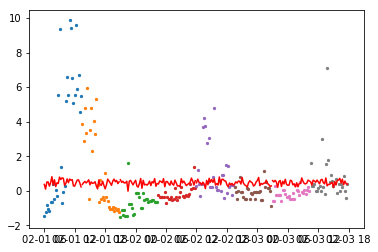

In [292]:
print("Testing with batch size", batch_size, "for", num_batch_test, "batches")

nsamples = 100
lnk = 0

y_pred = np.empty( (num_batch_test*batch_size, y_test.shape[2]))
samples = np.empty( (nsamples, batch_size, y_test.shape[2]) )
t = 0
for x_data, y_data in data_test:
    for s in range(nsamples):
        samples[s] = mod(x_data, training=False).sample()
    y_pred[t*batch_size:(t+1)*batch_size] = samples.mean(axis = 0)
    plt.plot(y_ix_test[t*batch_size:(t+1)*batch_size], y_pred[t*batch_size:(t+1)*batch_size,lnk], c = 'r')
    plt.scatter(y_ix_test[t*batch_size:(t+1)*batch_size], y_test[t*batch_size:(t+1)*batch_size,:,lnk], s=5)
    t = t+1

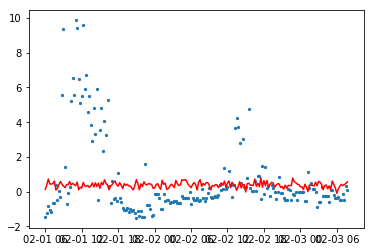

In [271]:
lnk = 0
plt.plot(y_ix_test[:num_batch_test*batch_size], y_pred[:,lnk], c = 'r')
plt.scatter(y_ix_test[:num_batch_test*batch_size], y_test[:num_batch_test*batch_size,:,lnk], s=5)

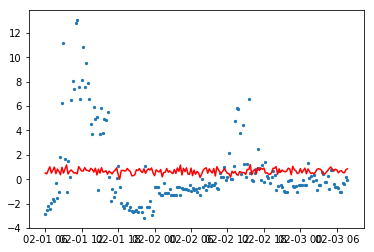

In [217]:
plt.plot(y_ix_test[:num_batch_test*batch_size], np.sum(y_pred, axis = 1), c = 'r')
plt.scatter(y_ix_test[:num_batch_test*batch_size], np.sum(y_test[:num_batch_test*batch_size], axis = 2), s=5)

In [31]:
t = 10
data_test = tf.data.Dataset.from_tensor_slices((X_test[:(t*batch_size)], 
                                                y_test[:(t*batch_size)])).shuffle(1000).batch(batch_size)
nsamples = 1
y_pred = np.zeros((nsamples, t, batch_size, y_train.shape[2]))

i = 0
for x_data, y_data in data_test:
    y_pred[0, i, :, :] = mod(x_data, training = False).loc
    i = i+1
    print("Iteration: ", i)

## Combine batch dimensions so we have [N_TEST, N_SAMPLES, TIMESTEPS_OUT, LINKS]
y_pred = tf.reshape(y_pred, shape=(nsamples, t*batch_size, y_train.shape[2])).numpy()

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10


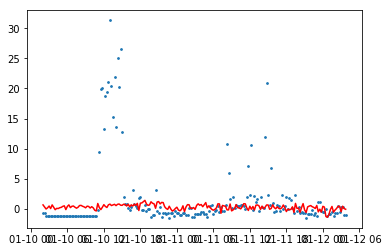

In [32]:
quantiles = np.array([0.05, 0.95])
lnk = 3
one_link = y_pred[:,:,lnk]
one_link_mean = np.mean(one_link, axis = 0)

plt.plot(y_ix_test[:t*batch_size], one_link_mean, c = 'r')
plt.scatter(y_ix_test[:t*batch_size], y_test[:(t*batch_size),0,lnk], s=3)

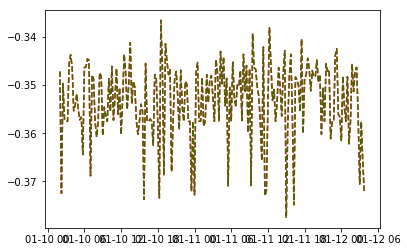

In [100]:
Y_pred_all_links = np.sum(y_pred, axis = 2)
bounds = np.quantile(Y_pred_all_links, quantiles, axis = 0)
mean = np.mean(Y_pred_all_links, axis = 0)
plt.plot(y_ix_test[:(t*batch_size)], bounds[0], c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], bounds[1], c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], mean, c = 'g', linestyle = "--", alpha = 0.7)

ValueError: x and y must have same first dimension, but have shapes (200,) and (50, 200)

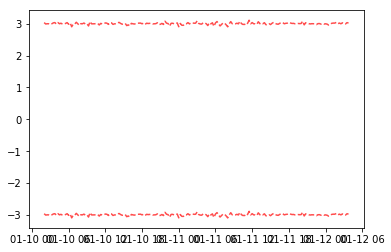

In [101]:
plt.plot(y_ix_test[:(t*batch_size)], y_upr[:,:,1], c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], y_lwr[:,:,1], c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], y_pred[:,:,1], c = 'g', linestyle = "--", alpha = 0.7)
plt.scatter(y_ix_test[:(t*batch_size)], y_test[:(t*batch_size),:,3], s = 10)

In [295]:
np.std(y_test[:,:,3])

6.378335974578605

In [67]:
np.sum(y_test, axis = 2).shape

(3159, 1)

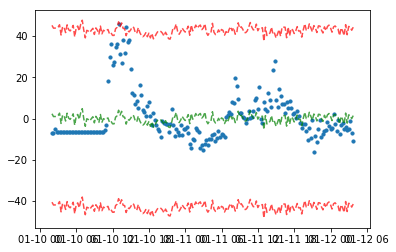

In [28]:
t = 10
data_test = tf.data.Dataset.from_tensor_slices((X_test[:(t*batch_size)], y_test[:(t*batch_size)])).shuffle(1000).batch(batch_size)

y_pred = np.zeros((t, batch_size,  y_train.shape[2]))
y_lwr  = np.zeros((t, batch_size,  y_train.shape[2]))
y_upr  = np.zeros((t, batch_size,  y_train.shape[2]))

i = 0
for x_data, y_data in data_test:
    y_pred_dist = mod(x_data, training = False)
    y_pred[i] = y_pred_dist.loc
    y_lwr[i] = y_pred[i] - 2*y_pred_dist.stddev()
    y_upr[i] = y_pred[i] + 2*y_pred_dist.stddev()
    i = i+1
## Combine batch dimensions so we have [N_TEST, N_SAMPLES, TIMESTEPS_OUT, LINKS]
y_pred = tf.reshape(y_pred, shape = (t*batch_size,  y_train.shape[1], y_train.shape[2])).numpy()
y_lwr = tf.reshape(y_lwr, shape = (t*batch_size,  y_train.shape[1], y_train.shape[2])).numpy()
y_upr = tf.reshape(y_upr, shape = (t*batch_size,  y_train.shape[1], y_train.shape[2])).numpy()

plt.plot(y_ix_test[:(t*batch_size)], np.sum(y_lwr, axis = 2), c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], np.sum(y_upr, axis = 2), c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], np.sum(y_pred, axis = 2), c = 'g', linestyle = "--", alpha = 0.7)
plt.scatter(y_ix_test[:(t*batch_size)], np.sum(y_test[:t*batch_size], axis = 2), s = 10)
plt.show()

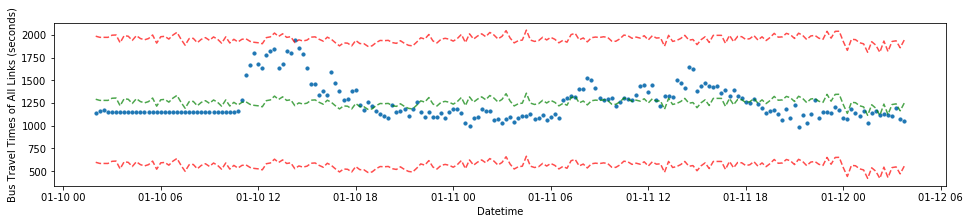

In [29]:
Y_lwr  = (y_lwr * y_std_test[:(t*batch_size)]) + y_mean_test[:(t*batch_size)]
Y_upr  = (y_upr * y_std_test[:(t*batch_size)]) + y_mean_test[:(t*batch_size)]
Y_pred      = (y_pred * y_std_test[:(t*batch_size)]) + y_mean_test[:(t*batch_size)]

## Sum across links for visualisation
Y_true = y_test * y_std_test + y_mean_test
Y_naive = y_mean_test
Y_true_total = np.sum(Y_true[:(t*batch_size)] , axis = 2)
Y_naive_total = np.sum(Y_naive[:(t*batch_size)], axis = 2)
Y_lwr_total = np.sum(Y_lwr[:(t*batch_size)], axis = 2)
Y_upr_total = np.sum(Y_upr, axis = 2)
Y_pred_total = np.sum(Y_pred, axis = 2)

fig, ax = plt.subplots(figsize = (16,3))
plt.ylabel("Bus Travel Times of All Links (seconds)")
plt.xlabel("Datetime")

#ax.xaxis.set_major_formatter(DateFormatter("%d"))
plt.plot(y_ix_test[:(t*batch_size)], Y_upr_total, c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], Y_lwr_total, c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], Y_pred_total, c = 'g', linestyle = "--", alpha = 0.7)
plt.scatter(y_ix_test[:(t*batch_size)], Y_true_total, s = 10)
plt.show()

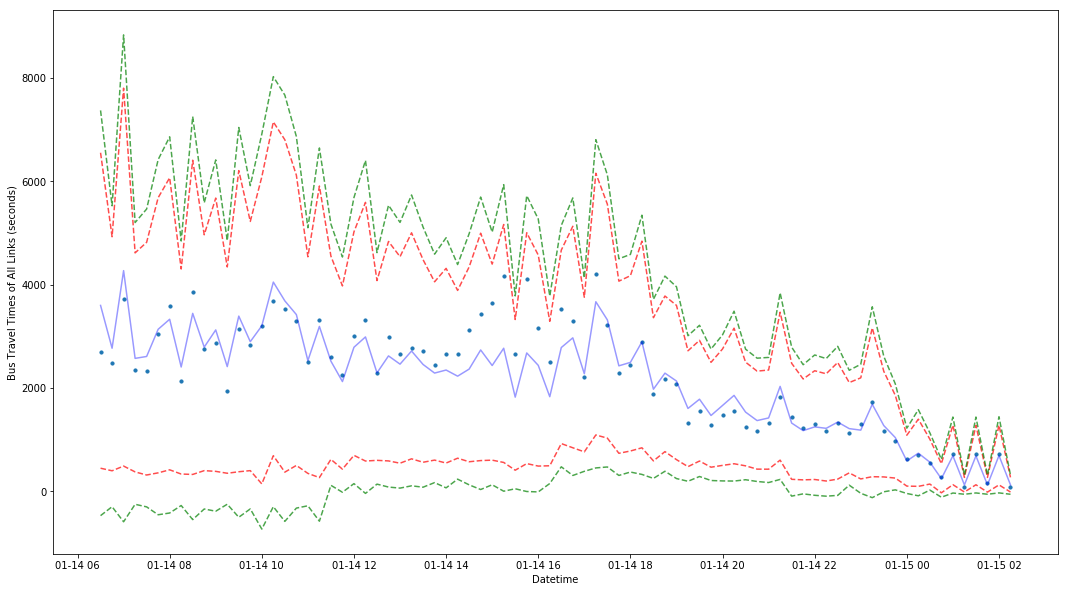

In [49]:
Y_pred_lwr1  = (y_pred_quan[0] * y_std_test[:(t*batch_size)]) + y_mean_test[:(t*batch_size)]
Y_pred_lwr2  = (y_pred_quan[1] * y_std_test[:(t*batch_size)]) + y_mean_test[:(t*batch_size)]
Y_pred_med   = (y_pred_quan[2] * y_std_test[:(t*batch_size)]) + y_mean_test[:(t*batch_size)]
Y_pred_upr2  = (y_pred_quan[3] * y_std_test[:(t*batch_size)]) + y_mean_test[:(t*batch_size)]
Y_pred_upr1  = (y_pred_quan[4] * y_std_test[:(t*batch_size)]) + y_mean_test[:(t*batch_size)]

## Sum across links for visualisation
Y_true = y_test * y_std_test + y_mean_test
Y_naive = y_mean_test
Y_true_total = np.sum(Y_true[:(t*batch_size)] * y_num_meas_test[:(t*batch_size)], axis = 2)
Y_naive_total = np.sum(Y_naive[:(t*batch_size)] * y_num_meas_test[:(t*batch_size)], axis = 2)
Y_pred_med_total = np.sum(Y_pred_med[:(t*batch_size)] * y_num_meas_test[:(t*batch_size)], axis = 2)
Y_pred_lwr1_total = np.sum(Y_pred_lwr1 * y_num_meas_test[:(t*batch_size)], axis = 2)
Y_pred_lwr2_total = np.sum(Y_pred_lwr2 * y_num_meas_test[:(t*batch_size)], axis = 2)
Y_pred_upr1_total = np.sum(Y_pred_upr1 * y_num_meas_test[:(t*batch_size)], axis = 2)
Y_pred_upr2_total = np.sum(Y_pred_upr2 * y_num_meas_test[:(t*batch_size)], axis = 2)

fig, ax = plt.subplots(figsize = (18,10))
plt.ylabel("Bus Travel Times of All Links (seconds)")
plt.xlabel("Datetime")

#ax.xaxis.set_major_formatter(DateFormatter("%d"))
plt.plot(y_ix_test[:(t*batch_size)], Y_pred_lwr2_total, c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], Y_pred_upr2_total, c = 'r', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], Y_pred_lwr1_total, c = 'g', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], Y_pred_upr1_total, c = 'g', linestyle = "--", alpha = 0.7)
plt.plot(y_ix_test[:(t*batch_size)], Y_pred_med_total, c = 'b', alpha = 0.4)
plt.scatter(y_ix_test[:(t*batch_size)], Y_true_total, s = 10)
plt.show()

In [ ]:
v = np.linspace(0 + 1e-4, 8, 400)
p = mod.y_std[3].prob(v)
plt.plot(v, p)